In [1]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.layers import SpatialDropout1D, Dense, Dropout, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot as plt
from ast import literal_eval
from scipy.stats.stats import pearsonr

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Import dataset
df = pd.read_csv("lda_labeled_master.csv")
df = df.rename(columns={"Unnamed: 0": "id"})
df.head()

,id,subject,from,date,to,label,thread,time,hour,month,...,subjectivity,num_qm,num_em,hashtag,prop_upper,num_full_upper,num_repeated,matrix,scores,concepts
0,0,Event for Freshmen: Discover career opportunit...,"""RippleMatch"" <katebeckman@ripplematch.com>",2021-02-22 20:11:34+00:00,tanishkumar@berkeley.edu,"Inbox,Important,Category Promotions,Unread",1.692428e+18,20:11:34,20,2,...,0.000000,0,1,0,0.115942,1,0,"[0.89521277, 0.020943033, 0.02106695, 0.020961...",0.895205,0
1,5,Complete your setup with the Slack desktop app,"""Slack"" <no-reply@email.slackhq.com>",2021-01-21 17:02:05+00:00,<tanishkumar@berkeley.edu>,"Inbox,Important,Category Promotions,Unread",1.689517e+18,17:02:05,17,1,...,0.400000,0,0,0,0.043478,0,0,"[0.19459948, 0.027835023, 0.02783517, 0.694059...",0.694060,3
2,12,Are you ready to play?,#ERROR!,2020-12-15 20:06:10+00:00,tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1.686176e+18,20:06:10,20,12,...,0.500000,1,0,0,0.045455,0,0,"[0.055558477, 0.3885321, 0.388899, 0.055893436...",0.388899,2
3,13,"Gadabout - plus, Go behind the scenes of our n...",#ERROR!,2021-02-01 10:14:58+00:00,<tanishkumar@berkeley.edu>,"Inbox,Category Promotions,Unread",1.690487e+18,10:14:58,10,2,...,0.577273,0,0,0,0.037037,0,0,"[0.021187034, 0.020874625, 0.020880118, 0.7477...",0.747757,3
4,16,General Registration is now open for Winter/Sp...,Mission College <nadler@wvm.edu>,2020-12-07 18:45:42+00:00,tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1.685446e+18,18:45:42,18,12,...,0.500000,0,1,0,0.078431,0,0,"[0.027871301, 0.027813246, 0.39802405, 0.19351...",0.397999,2


In [3]:
# Extract the values from matrix
df['matrix'] = df['matrix'].apply(literal_eval)
emotions = pd.DataFrame(df['matrix'].tolist(), columns=['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity'])
emotions['id'] = df['id']

In [4]:
# Clean the subject lines
cleaned = df[['id','subject']]
cleaned['subject'] = cleaned['subject'].str.lower()
cleaned['subject'] = cleaned['subject'].str.replace('[^\w\s]',' ')
cleaned = pd.merge(cleaned, emotions, left_on='id', right_on='id')
cleaned = cleaned.fillna(0)
cleaned.head()

<ipython-input-4-f7afdb384d94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['subject'] = cleaned['subject'].str.lower()
<ipython-input-4-f7afdb384d94>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['subject'] = cleaned['subject'].str.replace('[^\w\s]',' ')


,id,subject,enthusiasm,urgency,surprise,trust,curiosity,exclusivity
0,0,event for freshmen discover career opportunit...,0.895213,0.020943,0.021067,0.020962,0.020947,0.020869
1,5,complete your setup with the slack desktop app,0.194599,0.027835,0.027835,0.694060,0.027835,0.027835
2,12,are you ready to play,0.055558,0.388532,0.388899,0.055893,0.055558,0.055558
3,13,gadabout plus go behind the scenes of our n...,0.021187,0.020875,0.020880,0.747766,0.020858,0.168434
4,16,general registration is now open for winter sp...,0.027871,0.027813,0.398024,0.193520,0.324874,0.027898


In [5]:
cleaned.isnull().values.any()

False

In [6]:
# Create X and Y and split training and test sets
x = cleaned['subject'].values
y = cleaned[['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity']].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [7]:
# Tokenize the words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
words_to_index = tokenizer.word_index
len(words_to_index)

9923

In [8]:
# Pad the sequences
train_sequences = tokenizer.texts_to_sequences(x_train)
x_train_indices = pad_sequences(train_sequences, padding='post', maxlen=20)
test_sequences = tokenizer.texts_to_sequences(x_test)
x_test_indices = pad_sequences(test_sequences, padding='post', maxlen=20)

In [9]:
# Read GloVe vectors
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector('glove.6b.100d.txt')

In [10]:
# Create embedding layer
vocab_len = len(words_to_index)
emb_dim = 100
input_shape=(20, )
hits = 0
misses = 0

emb_matrix = np.zeros((vocab_len, emb_dim))

for word, i in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[i-1, :] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 8793 words (1130 misses)


In [11]:
# Model Creation
emb_layer = Embedding(vocab_len, emb_dim, input_shape=input_shape, weights=[emb_matrix], trainable=False)
keras.backend.clear_session()
model = keras.Sequential()
model.add(emb_layer)
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(150, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(6, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [12]:
x_train_indices

array([[ 784,  785,    2, ...,    0,    0,    0],
       [  10, 3444, 3445, ...,    0,    0,    0],
       [  17,  663,   15, ...,    0,    0,    0],
       ...,
       [  70,  129,  164, ...,    0,    0,    0],
       [   4,  344, 1826, ...,    0,    0,    0],
       [  10, 2453,   35, ...,    0,    0,    0]])

In [13]:
y_train

array([[0.03335294, 0.43355662, 0.43303156, 0.03335288, 0.03335305,
        0.03335297],
       [0.0334746 , 0.03337724, 0.03347392, 0.8329159 , 0.03335498,
        0.03340337],
       [0.24249883, 0.49510357, 0.02386519, 0.02389482, 0.02381879,
        0.19081879],
       ...,
       [0.7884805 , 0.08657275, 0.01192443, 0.01194361, 0.01196148,
        0.08911718],
       [0.83331406, 0.03333718, 0.03333719, 0.03333718, 0.03333721,
        0.0333372 ],
       [0.05793087, 0.71700317, 0.05558374, 0.05749254, 0.05558388,
        0.05640579]])

In [14]:
# Fit the model
history = model.fit(x_train_indices, y_train, validation_split=0.1, batch_size=32, epochs=10, shuffle=False, verbose=2)

Epoch 1/10
327/327 - 33s - loss: 1.7601 - accuracy: 0.2640 - val_loss: 1.7129 - val_accuracy: 0.3419
Epoch 2/10
327/327 - 8s - loss: 1.7123 - accuracy: 0.3364 - val_loss: 1.6724 - val_accuracy: 0.3885
Epoch 3/10
327/327 - 8s - loss: 1.6752 - accuracy: 0.3895 - val_loss: 1.6390 - val_accuracy: 0.4376
Epoch 4/10
327/327 - 8s - loss: 1.6376 - accuracy: 0.4306 - val_loss: 1.6212 - val_accuracy: 0.4513
Epoch 5/10
327/327 - 7s - loss: 1.6084 - accuracy: 0.4646 - val_loss: 1.5925 - val_accuracy: 0.4806
Epoch 6/10
327/327 - 8s - loss: 1.5732 - accuracy: 0.5043 - val_loss: 1.5666 - val_accuracy: 0.5090
Epoch 7/10
327/327 - 8s - loss: 1.5503 - accuracy: 0.5218 - val_loss: 1.5485 - val_accuracy: 0.5349
Epoch 8/10
327/327 - 7s - loss: 1.5273 - accuracy: 0.5501 - val_loss: 1.5331 - val_accuracy: 0.5426
Epoch 9/10
327/327 - 7s - loss: 1.5094 - accuracy: 0.5709 - val_loss: 1.5214 - val_accuracy: 0.5633
Epoch 10/10
327/327 - 7s - loss: 1.4891 - accuracy: 0.5842 - val_loss: 1.5117 - val_accuracy: 0.557

In [15]:
y_pred = model.predict(x_test_indices)
y_pred

array([[0.34615597, 0.15650484, 0.12904088, 0.12458929, 0.13167703,
        0.11203201],
       [0.09757742, 0.15004979, 0.12112677, 0.17671049, 0.14762804,
        0.30690753],
       [0.09255891, 0.30751327, 0.25110525, 0.12841414, 0.07995182,
        0.14045659],
       ...,
       [0.03206728, 0.202813  , 0.61736065, 0.05595326, 0.03900156,
        0.05280424],
       [0.03306577, 0.3437387 , 0.45526272, 0.04976016, 0.08133275,
        0.03683991],
       [0.08143537, 0.10080489, 0.21744022, 0.23378755, 0.20594524,
        0.16058673]], dtype=float32)

In [16]:
y_test

array([[0.63325614, 0.03333637, 0.03363117, 0.23281075, 0.03338389,
        0.0335817 ],
       [0.02783398, 0.36181438, 0.02783396, 0.359606  , 0.02783422,
        0.19507746],
       [0.04176696, 0.04255955, 0.7900681 , 0.04198601, 0.04169185,
        0.04192756],
       ...,
       [0.03333431, 0.03389261, 0.8326557 , 0.03344868, 0.03333432,
        0.03333432],
       [0.0333343 , 0.03394266, 0.8323292 , 0.03354846, 0.03337799,
        0.03346735],
       [0.0333352 , 0.03399595, 0.6322291 , 0.03363342, 0.23328698,
        0.03351935]])

In [17]:
# Calculate the loss and accuracy
accr = model.evaluate(x_test_indices, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

91/91 [==============================] - 1s 6ms/step - loss: 1.5103 - accuracy: 0.5694
Test set
  Loss: 1.510
  Accuracy: 0.569


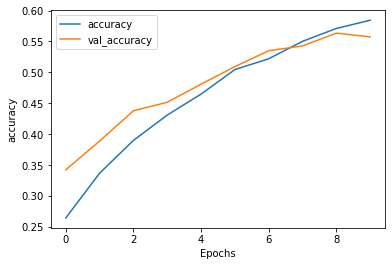

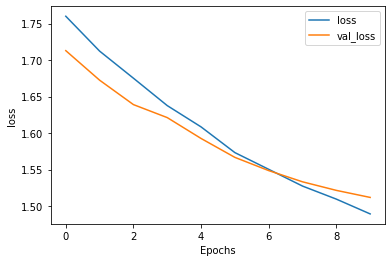

In [18]:
# Plot the loss and accuracy
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [19]:
# Determine the Pearson correlation coefficient
#y_pred = y_pred.flatten()
#y_test = y_test.flatten()
#def pearson_correlation(y1, y2):
    #return pearsonr(y1, y2)[0]
#pearson_correlation(y_pred, y_test)